In [2]:
import matplotlib.pyplot as plt
import numpy as np
from custom_poling.core.target import Target
from custom_poling.core.custom_crystal import CustomCrystal
from NeedALight.propagator import phases, Total_propK, JSAK, FtS2
from scipy.linalg import expm

This is a short example for using the momentum-time equations of motion for twin-beam generation. Note that this only works for a single pass configuration and does not include self- and cross-phase modulation.
We begin with setting up the parameters.

In [3]:
#Parameters
Np = 0.02 # Number of pump photons: Vary this to modify gain values
vp = 0.1  # pump velocity
l = 1.0  # amplification region length
sig = 1  # pump wave packet spread
a = 1.61 / 1.13  # from symmetric grp vel matching

def symmetric_v(vp, sig, l, a):
    vi = vp / (1 - 2 * a * vp / (l * sig))
    vs = vp / (1 + 2 * a * vp / (l * sig))
    return vs, vi

vs, vi = symmetric_v(vp, sig, l, a)

# Crystal properties
Ndomain = 1000 #Number of spatial points for non-linear/crystal grid
dz = (l) / Ndomain
domain_width = dz
number_domains = Ndomain
L = number_domains * domain_width

#Momenta grid
nk=201 #Number of momentum values: Always choose a number ending in 1. That way you always have a momentum value = 0
k_ft = 200/L
dk = k_ft/nk
k = np.arange(-k_ft/2,k_ft/2,dk)

Next we need to choose whether or not the domain is apodized. We leave two different options to choose from.

Run the next box to generate an apodized domain giving rise to a Gaussian phase matching function in the low gain. Definition of Gaussian pump envelope also included. We use the code and follow the examples of Agata Branczyk: https://github.com/abranczyk/custom-poling

In [4]:
# Numerical integration parameters for Crystal Structure
k0 = np.pi / domain_width
k_range = 100/L
dkc = k_range/401
k_array = np.arange(k0-k_range/2,k0+k_range/2,dkc)

# Create a custom crystal object
custom_crystal_gauss = CustomCrystal(domain_width,number_domains)
domain_middles_gauss = custom_crystal_gauss.domain_middles

#Define and plot the target function
std = 10
height = 0.025
target_pmf_gauss = lambda k:1j*height*np.exp(-(k-k0)**2/(2*std**2))*np.exp(1j * L/2 * k)
target_gauss = Target(target_pmf_gauss,k_array)

# Compute and plot the target amplitude
target_amplitude_gauss = target_gauss.compute_amplitude(k0,domain_middles_gauss)

# Compute and plot the custom domains
custom_domains_gauss = custom_crystal_gauss.compute_domains(target_amplitude_gauss,k0)
domain = custom_domains_gauss * np.asarray([1, -1] * int(Ndomain / 2)+[1]) #The multiplication here sets the central momenta to 0


# defining gaussian pump pulse
def pump(x, scale=1):
    return np.exp(-((x) ** 2) / (2 * ((vp/sig)*scale) ** 2)) / np.power(np.pi * ((vp/sig)*scale)**2, 1 / 4)

#Proper scale factor so that Gaussian PMF and Gaussian Pump have the same width
sc=std/(2*a)

Run the next box to generate an unapodized domain giving rise to a Sinc phase matching function in the low gain. Definition of Gaussian pump envelope also included.

In [5]:
# Create a custom crystal object
custom_crystal_gauss = CustomCrystal(domain_width,number_domains)
domain_middles_gauss = custom_crystal_gauss.domain_middles

# defining gaussian pump pulse
def pump(x, scale=1):
    return np.exp(-((x) ** 2) / (2 * ((vp/sig)*scale) ** 2)) / np.power(np.pi * ((vp/sig)*scale)**2, 1 / 4)

#Domain for a tophat potential
domain=np.asarray([1] * int(Ndomain)+[1])
sc=1

Next we define the actual pump pulse in (z,t) space including the proper normalization; the list of points where the interaction is non-zero; the dispersion relations in momentum(k) space. We also include the time interval. Note that for good convergence/agreement with the (z,w) code for the values chosen, a time step of 0.05 or lower is needed. However, this takes a while and for general checks which are still close to NeedALight numbers, a step of 0.2 is fine.

In [16]:
#Defining pump envelope, dispersion relations, and (z,t) grids


#Pump function in (z,t)
Lambda =lambda x,t: np.sqrt(Np)*pump(x+l-vp*t,scale=1/sc)  
#'l 'here serves as z0, really just determined by spread of pulse. Just make sure it is initially out of crystal region.
#Note that here we already include Sqrt(Np) in the definition. Unlike the (z,w) code.


#Dispersion relations. Unlike (z,w) code, we can allow for higher orders of dispersions (terms propto k**2)
ws = vs*k
wi = vi*k

#Spatial grid values for the non-linear region/crystal.
z_list = domain_middles_gauss-l/2 


#Time gird
#Play around with time vector at your leisure. Currently chosen such that all pulses completely leave the crystal.
#Also chosen such that pump pulse ends at z=1.
t=np.arange(0,20+0.2,0.2)   

For the single pass structure, we can simply make use of all of the functions to generate all the desired/relevant quantities. The JSAK function will give us the JSA, the Schmidt number, as well as all the relevant moments.

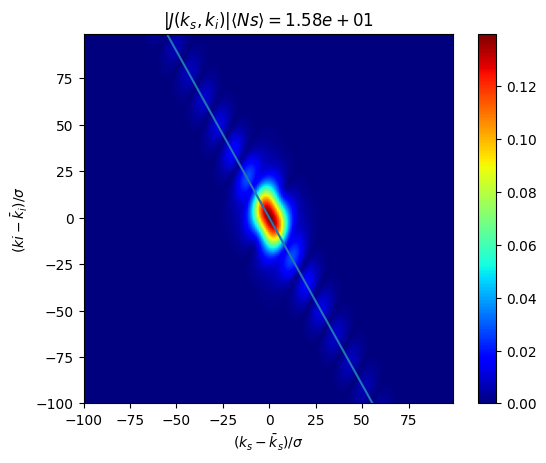

1.0515891960326353

In [17]:
#This generates the total propagator for the full time.
K = Total_propK(domain,Lambda,z_list,k,t,ws,wi)

#Generates JSA and other relevant matrices. Note that in this model, Free propagating phases are NOT REMOVED.
J, Ns, Schmidt, M, Nums, Numi = JSAK(K,dk)

fig, ax = plt.subplots()
im = ax.imshow(np.abs(J), cmap="jet", origin="lower", extent=[k[0],k[nk-1],k[0],k[nk-1]])
ax.plot(-(vs/vi)*k,k)
ax.set_xlabel(r"$(k_{s}-\bar{k}_{s})/\sigma$")
ax.set_ylabel(r"$(k{i}-\bar{k}_{i})/\sigma$")
ax.set_title(r"$|J(k_{s}, k_{i})|    \langle Ns \rangle = %1.2e $" %Ns)
plt.colorbar(im, orientation="vertical")
plt.show()
Schmidt 

The values of Ns and Schmidt# get closer in agreement to the (z,w) results as we decrease the timestep as mentioned above. Note that if one wants to compare the maximal value of the JSA using both methods, one needs to divide JSAK by Sqrt(vs*vi). This factor comes from the Jacobian and switching between momenta and frequency.

Here we look at the First output signal Schmidt mode. Note that since the free phases are not removed, as such they look much different than from NeedALight plots. Also note that we multiply by a phase factor such that the imaginary part is 0 at the origin.

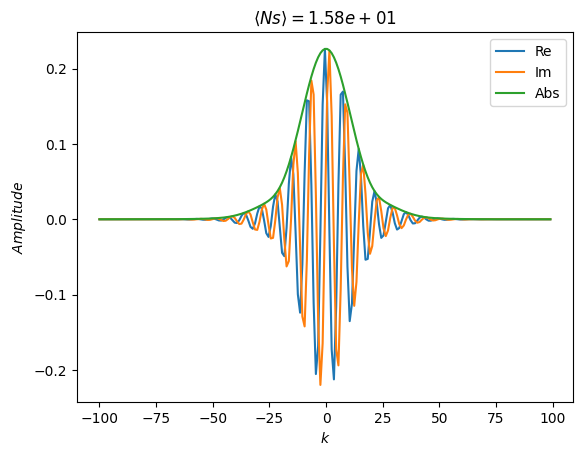

In [18]:
mark=1 #this just takes the first eigenmode of interest. Choose a different value to look at different ones.
val, u = np.linalg.eigh(Nums)

fig, ax1 = plt.subplots()

ax1.plot(k, np.real(np.exp(-1j*np.angle(u[(nk-1)//2,-mark]))*u[:,-mark]), label='Re') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(k, np.imag(np.exp(-1j*np.angle(u[(nk-1)//2,-mark]))*u[:,-mark]), label='Im')
ax1.plot(k, np.abs(np.exp(-1j*np.angle(u[(nk-1)//2,-mark]))*u[:,-mark]), label='Abs')
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()

Here we include a section where we remove the free phases to show similar plots obtained from NeedALight. We use the previously implemented 'phases' function but with different inputs. This is also only valid for a linear dispersion.

In [19]:
#Removing free propagating phases from propagator K
Nt=len(K)
Kphaseless = phases(K,-1/(vs-vp),1/(vi+vp),1/vp,t[-1],k)
Ksi = Kphaseless[0 : Nt // 2, Nt // 2 : Nt]
NumsFree = np.conj(Ksi) @ Ksi.T

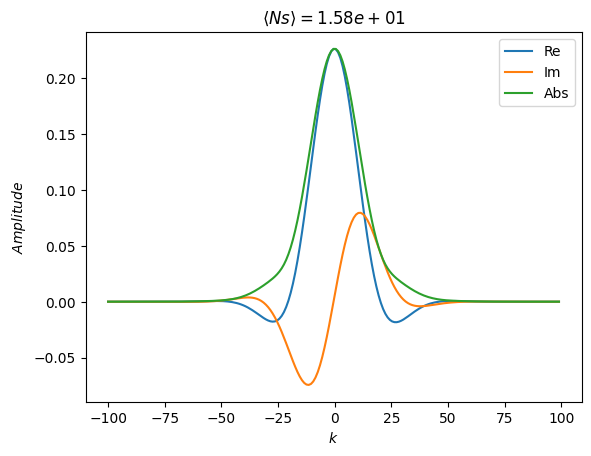

In [20]:
mark=1 #this just takes the first eigenmode of interest. Choose a different value to look at different ones.
val1, u1 = np.linalg.eigh(NumsFree)

fig, ax1 = plt.subplots()

ax1.plot(k, np.real(np.exp(-1j*np.angle(u1[(nk-1)//2,-mark]))*u1[:,-mark]), label='Re') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(k, np.imag(np.exp(-1j*np.angle(u1[(nk-1)//2,-mark]))*u1[:,-mark]), label='Im')
ax1.plot(k, np.abs(np.exp(-1j*np.angle(u1[(nk-1)//2,-mark]))*u1[:,-mark]), label='Abs')
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()

Next we define manual Fourier Transforms to plot energy densities back in Real Space. We also as well as the range of spatial interest (i.e. that includes section before and after the crystal)

In [21]:
#Defining fourier transforms and spatial range
Basic_ift = lambda z,k,func: np.sum(np.exp(1j*np.tensordot(z,k,axes=0))/np.sqrt(2*np.pi)*(k[1]-k[0])*func,axis=1)
Basic_ft = lambda z,k,func: np.sum(np.exp(-1j*np.tensordot(k,z,axes=0))/np.sqrt(2*np.pi)*(z[1]-z[0])*func,axis=1) #for when you want to input a vector and not a matrix
Basic_ift2D = lambda z,k,func: np.sum(np.sum(np.exp(1j*np.tensordot(z,k-k[:,np.newaxis],axes=0))/(2*np.pi)*((k[1]-k[0]))*func,axis=1),axis=1) #This is to take the FT of Nums and Numi,note the sign difference for the k's

zplot=np.arange(-2,2,0.005)

Now we introduce the Energy densities for all modes. We normalize such that at the final time, the intergral of the densities is 1. We also obtain the location of the density peaks.

In [22]:
#Energy densities <\psi(z,t)^\dagger \psi(z,t)>. Basically the 2D IFT of Nums and Numi
#These are at t[f]
NumsZ = np.real(Basic_ift2D(zplot,k,Nums))
NumiZ = np.real(Basic_ift2D(zplot,k,Numi))
Pump_E =Lambda(zplot,t[-1])*Lambda(zplot,t[-1])

#To see the evolution on the same scale, I normalize such that at t[f] the integral of the energy density is 1.
E_S_normed = NumsZ/Ns
E_I_normed = NumiZ/Ns
E_P_normed = Pump_E/Np

#This is to find the location of the peaks. Plotting for different gains will show if it differs.
zs=zplot[np.argmax(np.abs(NumsZ))]
zi=zplot[np.argmax(np.abs(NumiZ))]
zp=zplot[np.argmax(Pump_E)]

This is a plot of the energy densities at the end of the total evolution

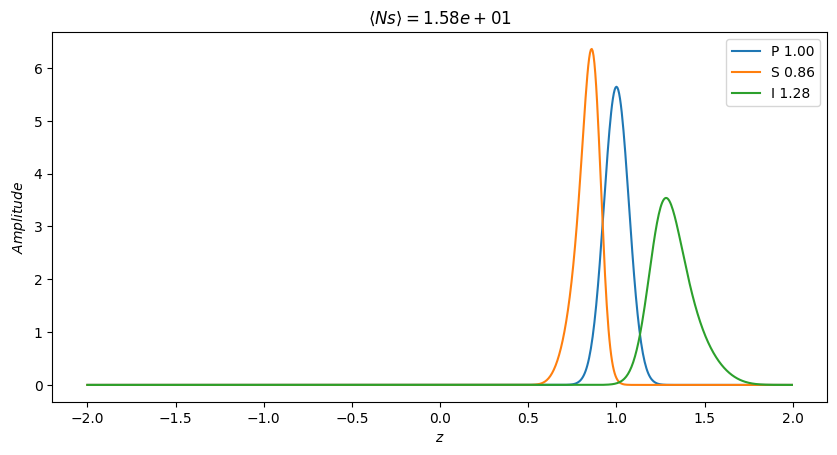

In [23]:
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
ax1.plot(zplot, E_P_normed, label='P %1.2f' %zp) #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(zplot, E_S_normed, label='S %1.2f' %zs)
ax1.plot(zplot, E_I_normed, label='I %1.2f' %zi)
ax1.set_xlabel(r"$z$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()
#plt.savefig('timeorder_highgain_finalposition.pdf')

For what follows, we analyze the peak density position as a function of time. This allows us to check average velocities at different point of the trajectory as well as help us visualize how things are moving.

In [24]:
#In case one wants to use different time settings than before.
t=np.arange(0,20+0.2,0.2)


This finds the peak positions at every point in time. We left a particular snippet of code commented out. This snippet allows one to save a figure of the energy densities at every point in time. Then one can combine all these images using the imageio package to make an aminated gif of the densities moving along.

In [25]:
#Initializing
KT = np.identity(2 * len(k), dtype=np.complex128)
dk = k[1]-k[0]
dt = t[1]-t[0]

zst = np.zeros_like(t)
zit = np.zeros_like(t)
zpt = np.zeros_like(t)
    
ind = 0    
#Constructing the diagonal blocks
Rs = np.diag(-1j*ws)
Ri = np.diag(1j*wi)
    
for i in t:
    S = 1j*FtS2(domain,Lambda,z_list,k,i)*dk/np.sqrt(2*np.pi)
    Q = np.block([[Rs,S],[np.conjugate(S),Ri]])
    KT = expm(Q*dt)@KT

    JT, NsT, SchmidtT, MT, NumsT, NumiT = JSAK(KT,dk) #T because they are temporary
    NumsZT = np.real(Basic_ift2D(zplot,k,NumsT))
    NumiZT = np.real(Basic_ift2D(zplot,k,NumiT))
    Pump_ET =Lambda(zplot,i)*Lambda(zplot,i)

    #To see the evolution on the same scale, I normalize such that at t[f] the integral of the energy density is 1.
    E_S_normedT = NumsZT/Ns
    E_I_normedT = NumiZT/Ns
    E_P_normedT = Pump_ET/Np

    zst[ind]=zplot[np.argmax(np.abs(NumsZT))]
    zit[ind]=zplot[np.argmax(np.abs(NumiZT))]
    zpt[ind]=zplot[np.argmax(Pump_ET)]
        
    ind=ind+1

    """fig, ax1 = plt.subplots()
    fig.set_figwidth(10)
    ax1.plot(zplot, E_P_normedT, label='P' ) 
    ax1.plot(zplot, E_S_normedT, label='S' )
    ax1.plot(zplot, E_I_normedT, label='I' )
    ax1.plot(zplot, (np.heaviside(zplot+1/2,0)-np.heaviside(zplot-1/2,0))*14, label='Crystal')
    ax1.set_xlabel(r"$z$")
    ax1.set_ylabel(r"$Amplitude$")
    ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
    ax1.set_ylim(0, 7)
    ax1.legend()
    plt.savefig(f'imgEmid_time_{i}.png', 
                transparent = False,  
                facecolor = 'white'
               )
    plt.close()"""

Run this commented out box to make a gif. Choose duration depending on number of frames you chose to generate depending on time-step. Requires loading "imageio"

In [14]:
#frames = []
#for i in t:
    #image = imageio.v2.imread(f'imgEmid_time_{i}.png')
    #frames.append(image)

#imageio.mimsave('evolution_time_mid.gif',frames, duration=200)   

Here we use a linear fit to find the average velocities in and out of the crystal. Play around with the ranges depending on time-step.

In [26]:
#Fitting lines
x_c = t[40:70]  #'c' means that we are inside the crystal
x_e = t[88:99]  # 'e' means that we are outside the crystal, towards the end of the evolution.

zs_c =  zst[40:70]
zs_e =  zst[88:99]

zi_c =  zit[40:70]
zi_e =  zit[88:99]


vsc, b = np.polyfit(x_c, zs_c, 1)
vse, b = np.polyfit(x_e, zs_e, 1)

vic, b = np.polyfit(x_c, zi_c, 1)
vie, b = np.polyfit(x_e, zi_e, 1)

This shows the peak Signal Energy Density position as a function of time. The vertical green lines represent the times when the Pump Peak passes the nonlinear interface. The horizontal red line represents the end of the crystal. The orange line is there for visualization, the slope of this line is the velocity INSIDE the crystal, which is different from the velocity outside. In the legend, vs=input velocity, vs_c=fitted velocity inside crystal, vs_e=fitted velocity outside the crystal. vs_e~vs

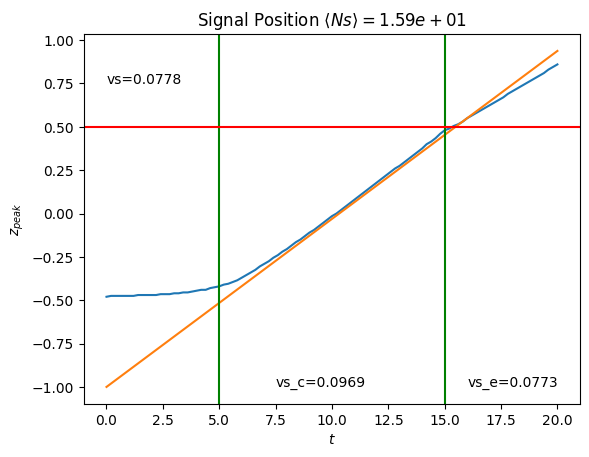

In [25]:
fig, ax1 = plt.subplots()
ax1.plot(t,zst)
ax1.plot(t,vsc*t-l)
ax1.text(0,0.75, 'vs=%1.4f' %vs)
ax1.text(7.5,-1, 'vs_c=%1.4f' %vsc)
ax1.text(16,-1, 'vs_e=%1.4f' %vse)
ax1.axvline(x=t[25],color='g')
ax1.axvline(x=t[75], color='g')
ax1.axhline(y=0.5, color='r')
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$z_{peak}$")
ax1.set_title(r"Signal Position $\langle Ns \rangle= %1.2e$" %Ns)
plt.show()
#plt.savefig('signal_position_time_high.pdf')

This shows the peak Idler Energy Density position as a function of time. The Vertical GREEN lines represent the times when the Pump Peak passes the nonlinear interface. The horizontal RED line represents the end of the crystal. The ORANGE line is there for visualization, the slope of this line is the velocity INSIDE the crystal, which is different from the velocity outside. In the legend, vi=input velocity, vi_c=fitted velocity inside crystal, vi_e=fitted velocity outside the crystal. vi_e~vi

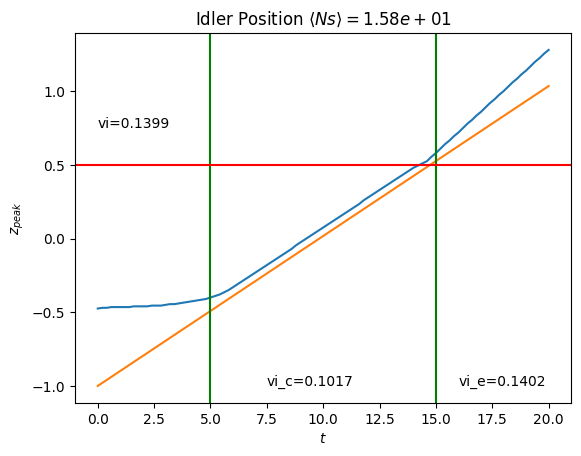

In [27]:
fig, ax1 = plt.subplots()
ax1.plot(t,zit)
ax1.plot(t,vic*t-l)
ax1.text(0,0.75, 'vi=%1.4f' %vi)
ax1.text(7.5,-1, 'vi_c=%1.4f' %vic)
ax1.text(16,-1, 'vi_e=%1.4f' %vie)
ax1.axvline(x=t[25],color='g')
ax1.axvline(x=t[75], color='g')
ax1.axhline(y=0.5, color='r')
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$z_{peak}$")
ax1.set_title(r"Idler Position $\langle Ns \rangle= %1.2e$" %Ns)
plt.show()
#plt.savefig('idler_position_time_high.pdf')